In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from scipy.stats import norm
import scipy
import pylab
from datetime import datetime, timedelta
from scipy.optimize import minimize
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import chi2

# ignore all warnings
import warnings 
warnings.filterwarnings('ignore')

# Importing data

'CL=F': WTI Crude Oil 

'NG=F': Henry Hub Natural Gas

'TTF=F': Dutch TTF Natural Gas 

'LNG': Cheniere Energy

'GLNG': Golar LNG Limited

'NGG': UK Power - National Grid 

In [2]:
# Fetch data
tickers = ['CL=F', 'NG=F', 'TTF=F', 'LNG', 'TELL', 'NGG', 'EUR=X']
start_date_0 = "2014-01-01"
end_date_0 = "2024-07-01"
data = yf.download(tickers, start=start_date_0, end=end_date_0)['Adj Close']
data.head()

[*********************100%***********************]  7 of 7 completed


,CL=F,EUR=X,LNG,NG=F,NGG,TELL,TTF=F
Date,,,,,,,
2014-01-01,NaN,0.72754,NaN,NaN,NaN,NaN,NaN
2014-01-02,95.440002,0.72639,42.204971,4.321,37.816071,8.16,NaN
2014-01-03,93.959999,0.73171,41.165154,4.304,38.033539,8.16,NaN
2014-01-06,93.430000,0.73551,42.078644,4.306,37.810181,8.32,NaN
2014-01-07,93.669998,0.73357,43.934765,4.299,37.733772,8.24,NaN


In [3]:
# convert all currency into USD
data['TTF=F_USD'] = data['TTF=F'] * data['EUR=X'] 
data.head()

,CL=F,EUR=X,LNG,NG=F,NGG,TELL,TTF=F,TTF=F_USD
Date,,,,,,,,
2014-01-01,NaN,0.72754,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,95.440002,0.72639,42.204971,4.321,37.816071,8.16,NaN,NaN
2014-01-03,93.959999,0.73171,41.165154,4.304,38.033539,8.16,NaN,NaN
2014-01-06,93.430000,0.73551,42.078644,4.306,37.810181,8.32,NaN,NaN
2014-01-07,93.669998,0.73357,43.934765,4.299,37.733772,8.24,NaN,NaN


In [4]:
# change column names
data = data[['CL=F', 'LNG', 'NG=F', 'NGG', 'TELL', 'TTF=F_USD']]
data.columns = ['CL', 'LNG', 'NG', 'NGG', 'TELL', 'TTF']
data.head(2)

,CL,LNG,NG,NGG,TELL,TTF
Date,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,95.440002,42.204971,4.321,37.816071,8.16,NaN


## EDA

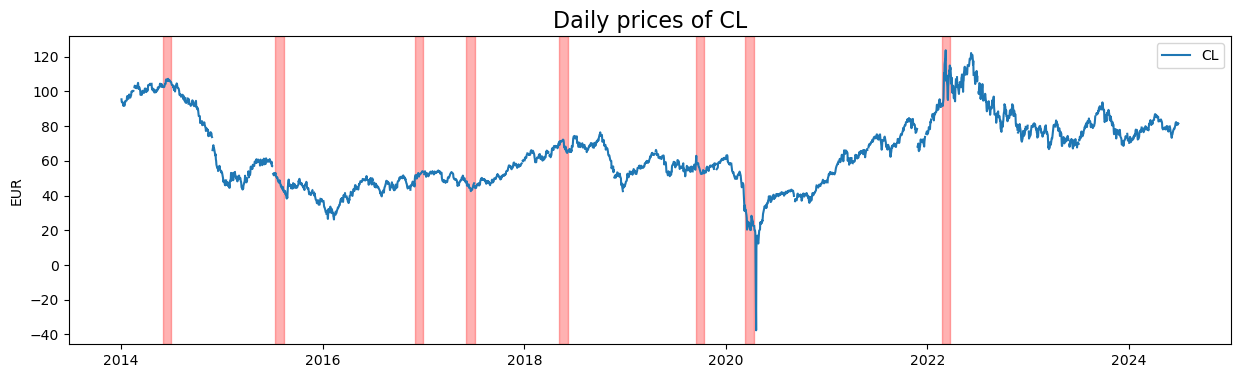

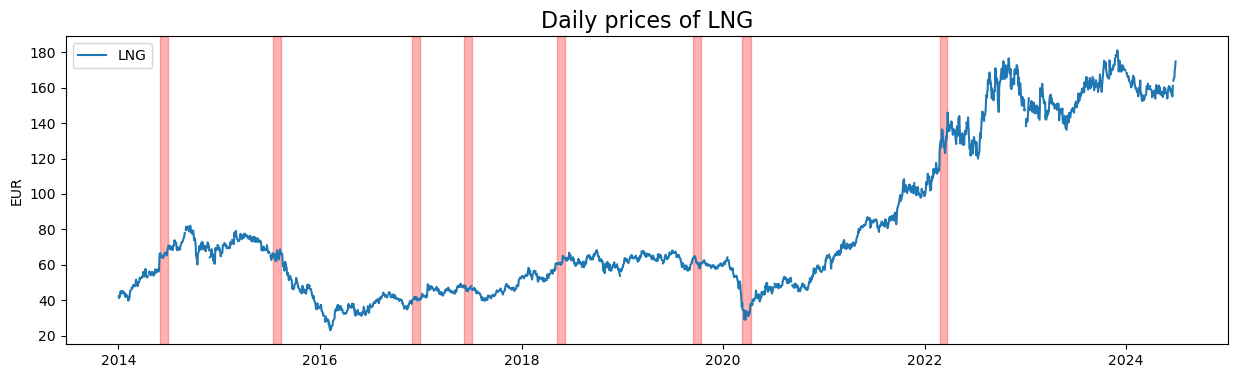

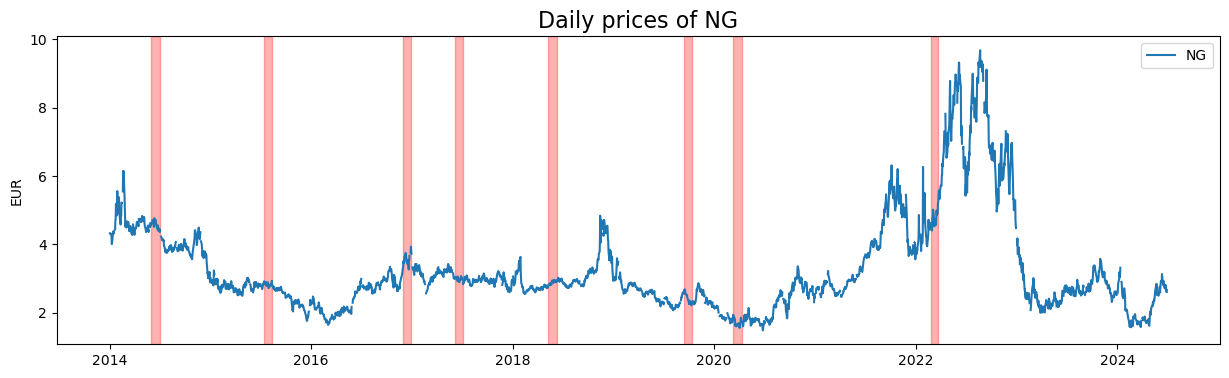

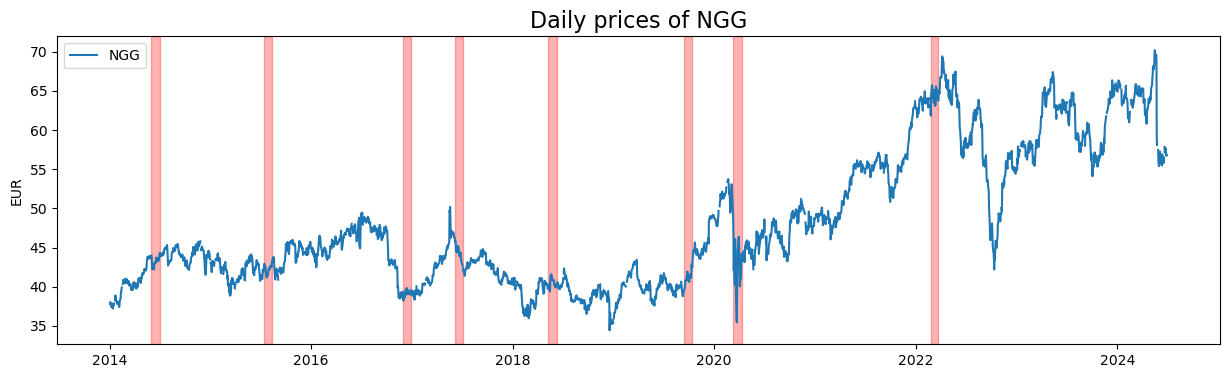

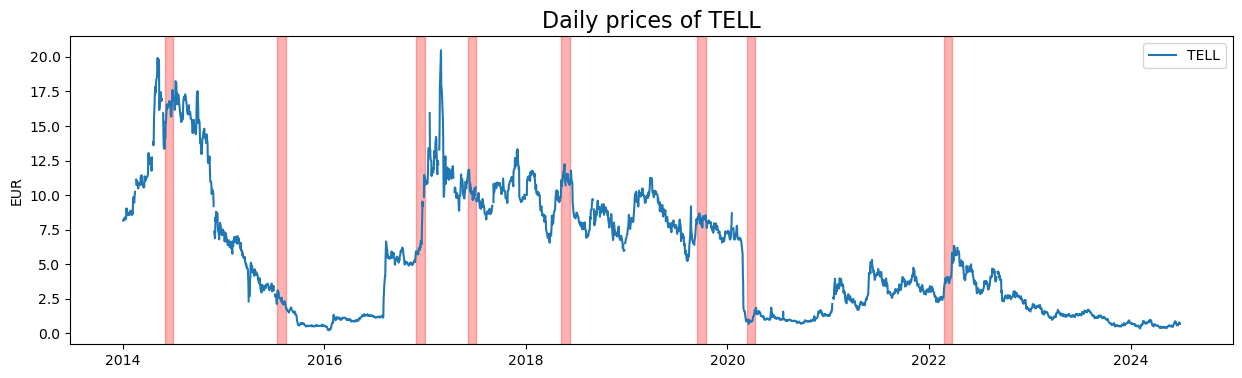

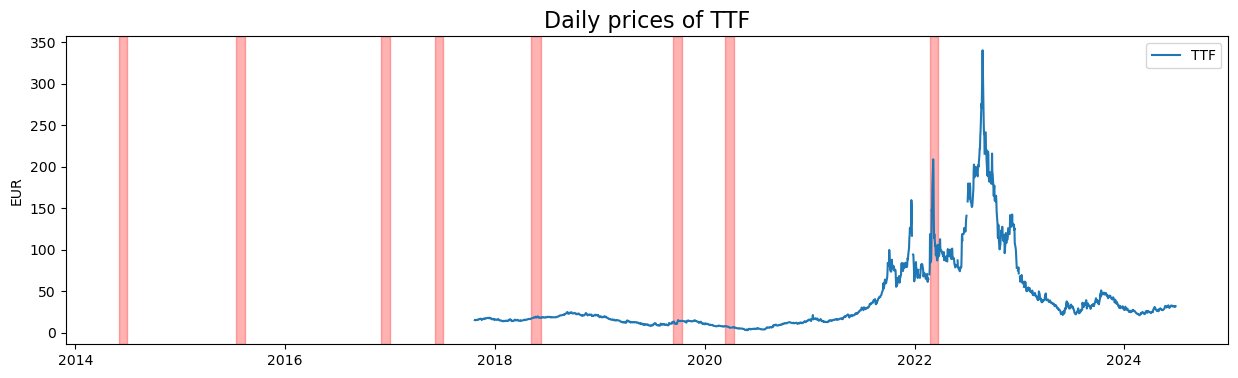

In [5]:
# mark the events when they happened 
highlight_periods = [
    ('2014-06-01', '2014-07-01'), # Oil Price Collapse started
    ('2015-07-14', '2015-08-14'), # Iran Nuclear Deal
    ('2016-11-30', '2016-12-30'), # OPEC Production Cuts
    ('2017-06-05', '2017-07-05'), # Qatar Diplomatic Crisis
    ('2018-05-08', '2018-06-09'), # U.S. Withdrawal from Iran Nuclear Deal
    ('2019-09-14', '2019-10-14'), # Attacks on Saudi Oil Facilities
    ('2020-03-11', '2020-04-11'), # COVID-19 Pandemic
    ('2022-02-24', '2022-03-24')  # Russia-Ukraine War
]

for column in data.columns:
    plt.figure(figsize=(15, 4))
    plt.plot(data.index, data[column], label=column)
    plt.ylabel("EUR")
    plt.title(f'Daily prices of {column}', fontsize=16)

    for start_date, end_date in highlight_periods:
        plt.axvspan(pd.Timestamp(start_date), pd.Timestamp(end_date), color='red', alpha=0.3)

    plt.legend()
    plt.show()


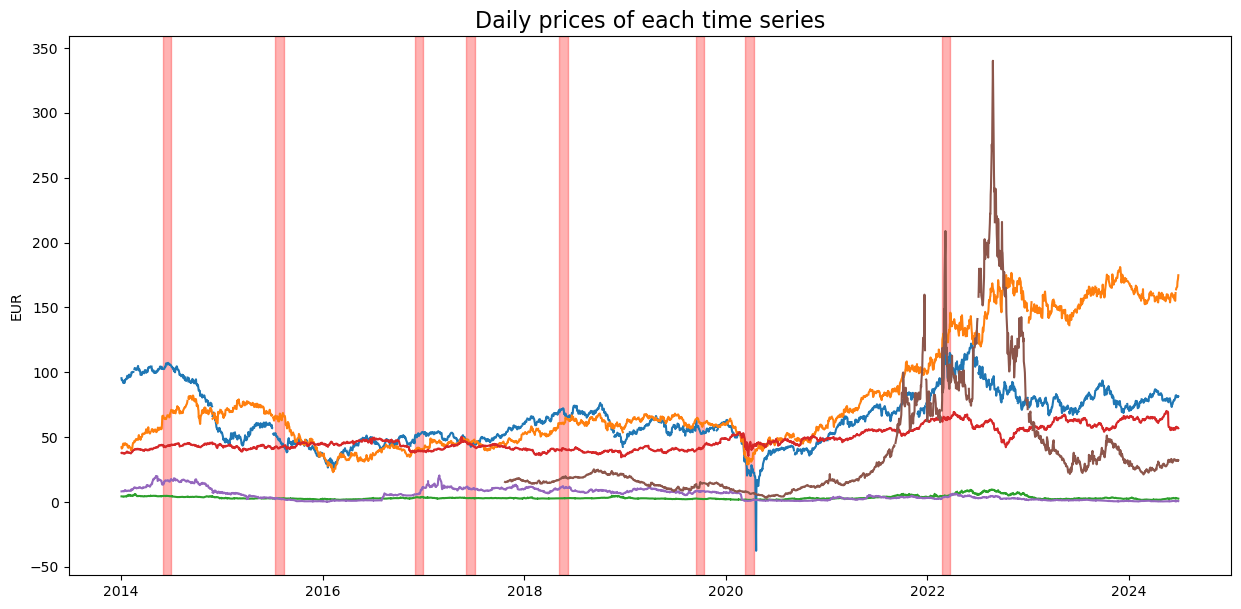

In [6]:
# plot all the tickers in 1 graph
plt.figure(figsize=(15, 7))
plt.plot(data.index, data.values)
plt.ylabel("EUR")
plt.title('Daily prices of each time series', fontsize=16)
for start_date, end_date in highlight_periods:
    plt.axvspan(pd.Timestamp(start_date), pd.Timestamp(end_date), color='red', alpha=0.3)
plt.show()

In [7]:
# fill all the missing values with the nearest price
for column in data.columns:
    data[column] = data[column].bfill()

In [8]:
# basic examination
data.describe()

,CL,LNG,NG,NGG,TELL,TTF
count,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000
mean,64.403419,79.633960,3.258057,48.093808,5.494145,30.701572
std,20.192547,42.909060,1.400244,8.510229,4.446299,38.276351
min,-37.630001,22.982903,1.482000,34.440693,0.230000,3.186027
25%,49.047501,47.625152,2.511000,41.373975,1.350000,15.390972
50%,61.085001,63.312317,2.834000,44.924580,4.160000,15.390972
75%,78.097500,101.532755,3.634750,55.239649,8.717500,27.426407
max,123.699997,181.157394,9.680000,70.192070,20.469999,340.172891


In [9]:
# remove negative values in Crude Oil
data_2 = data[data['CL'] >= 0]

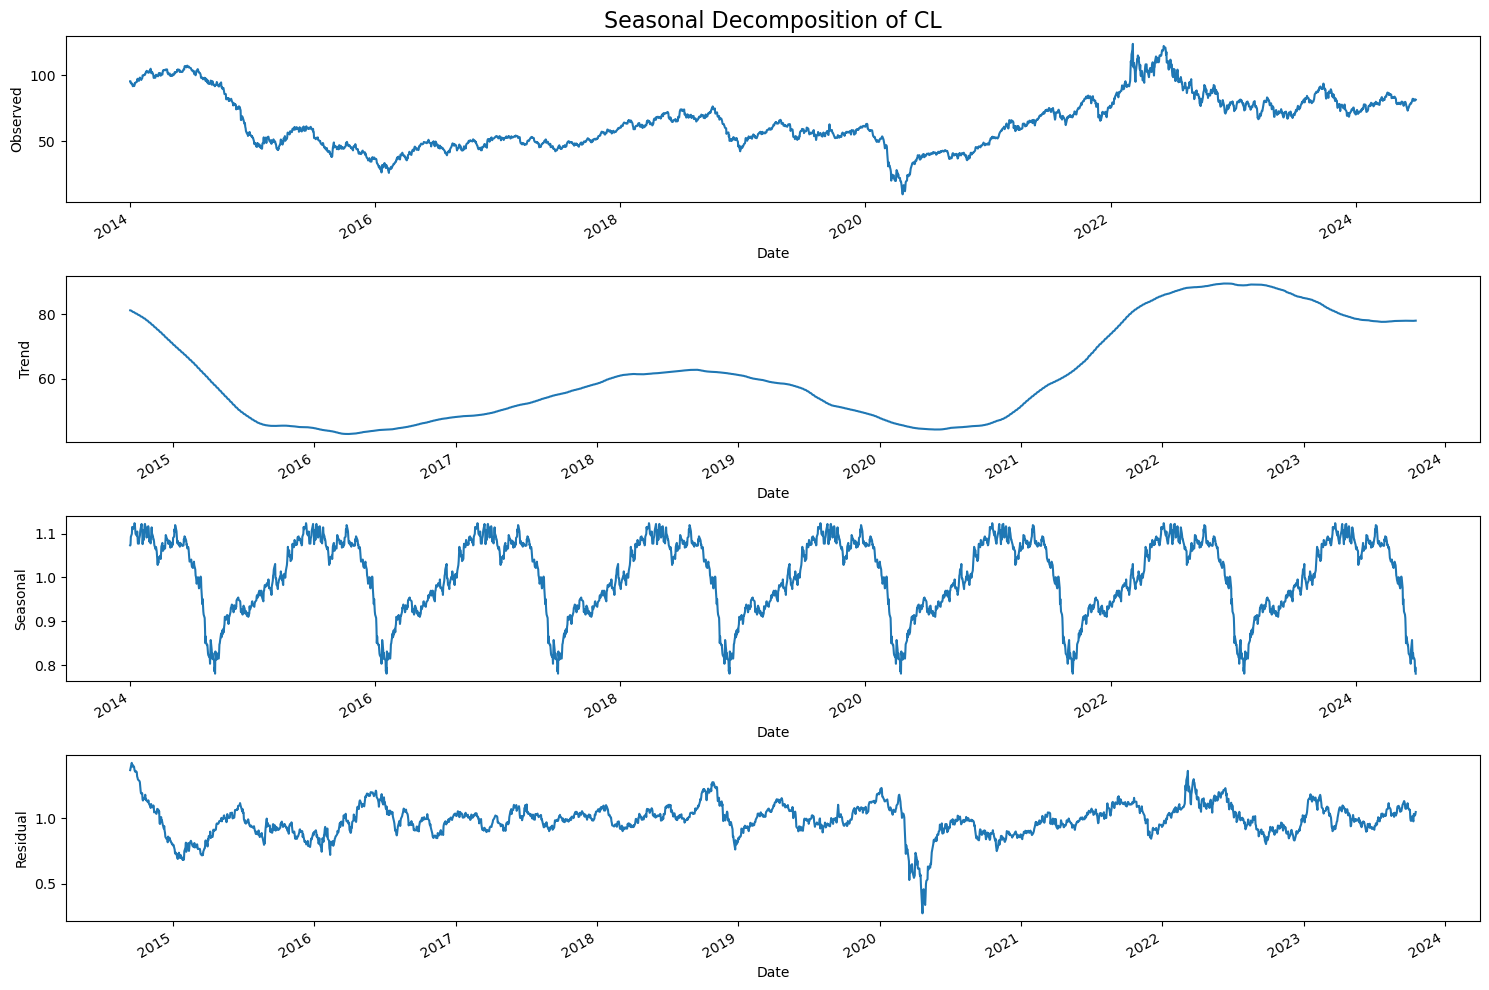

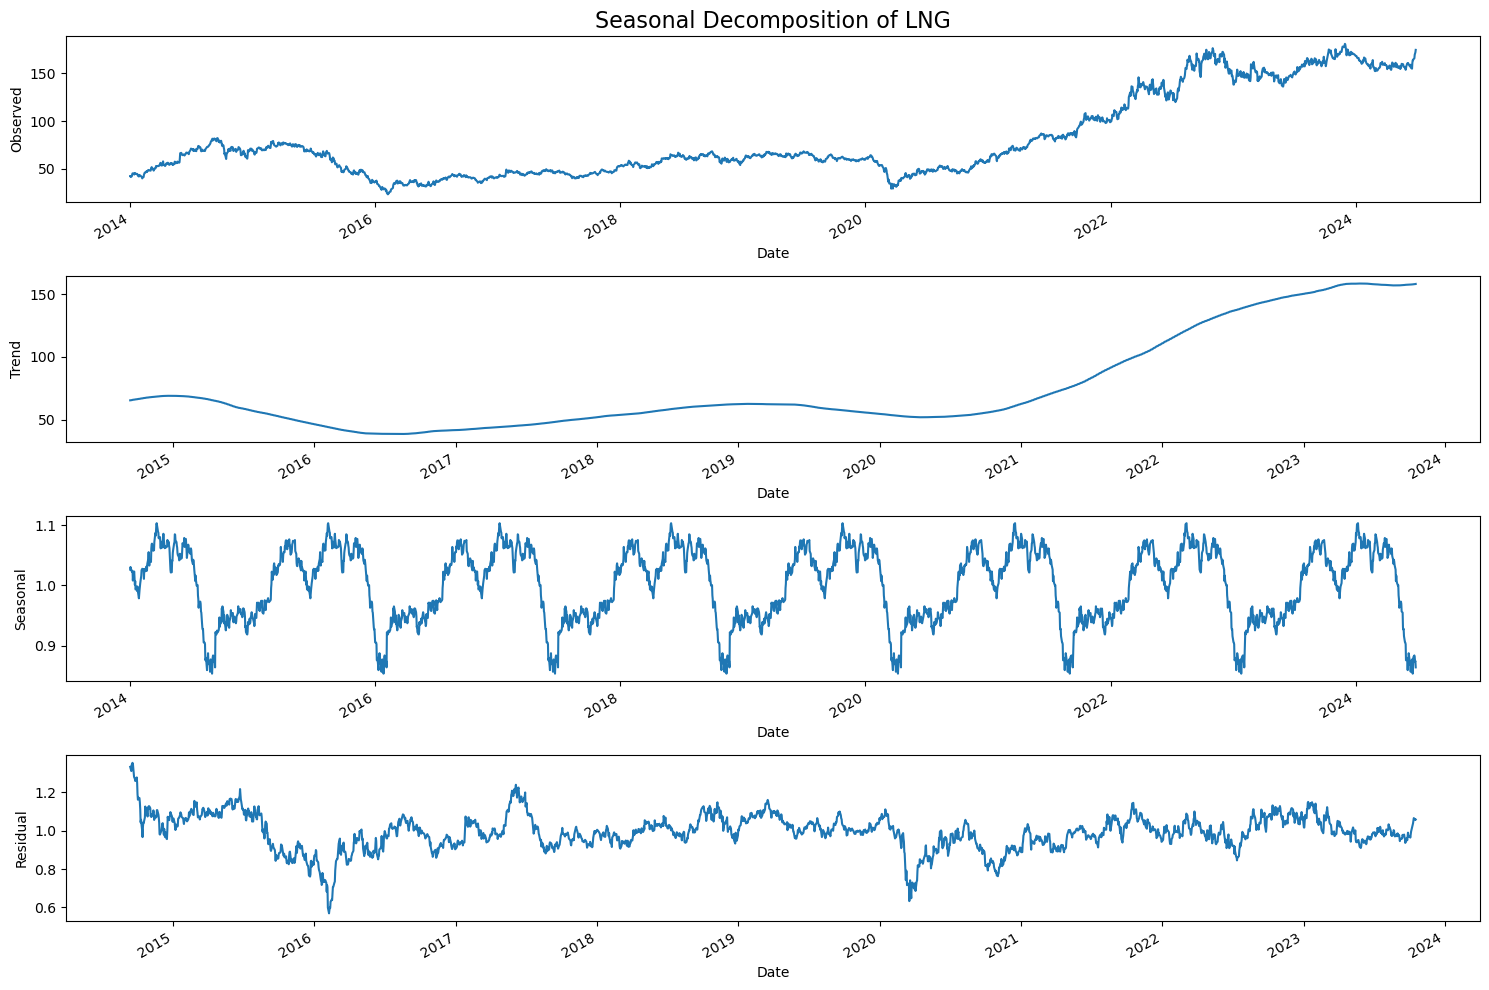

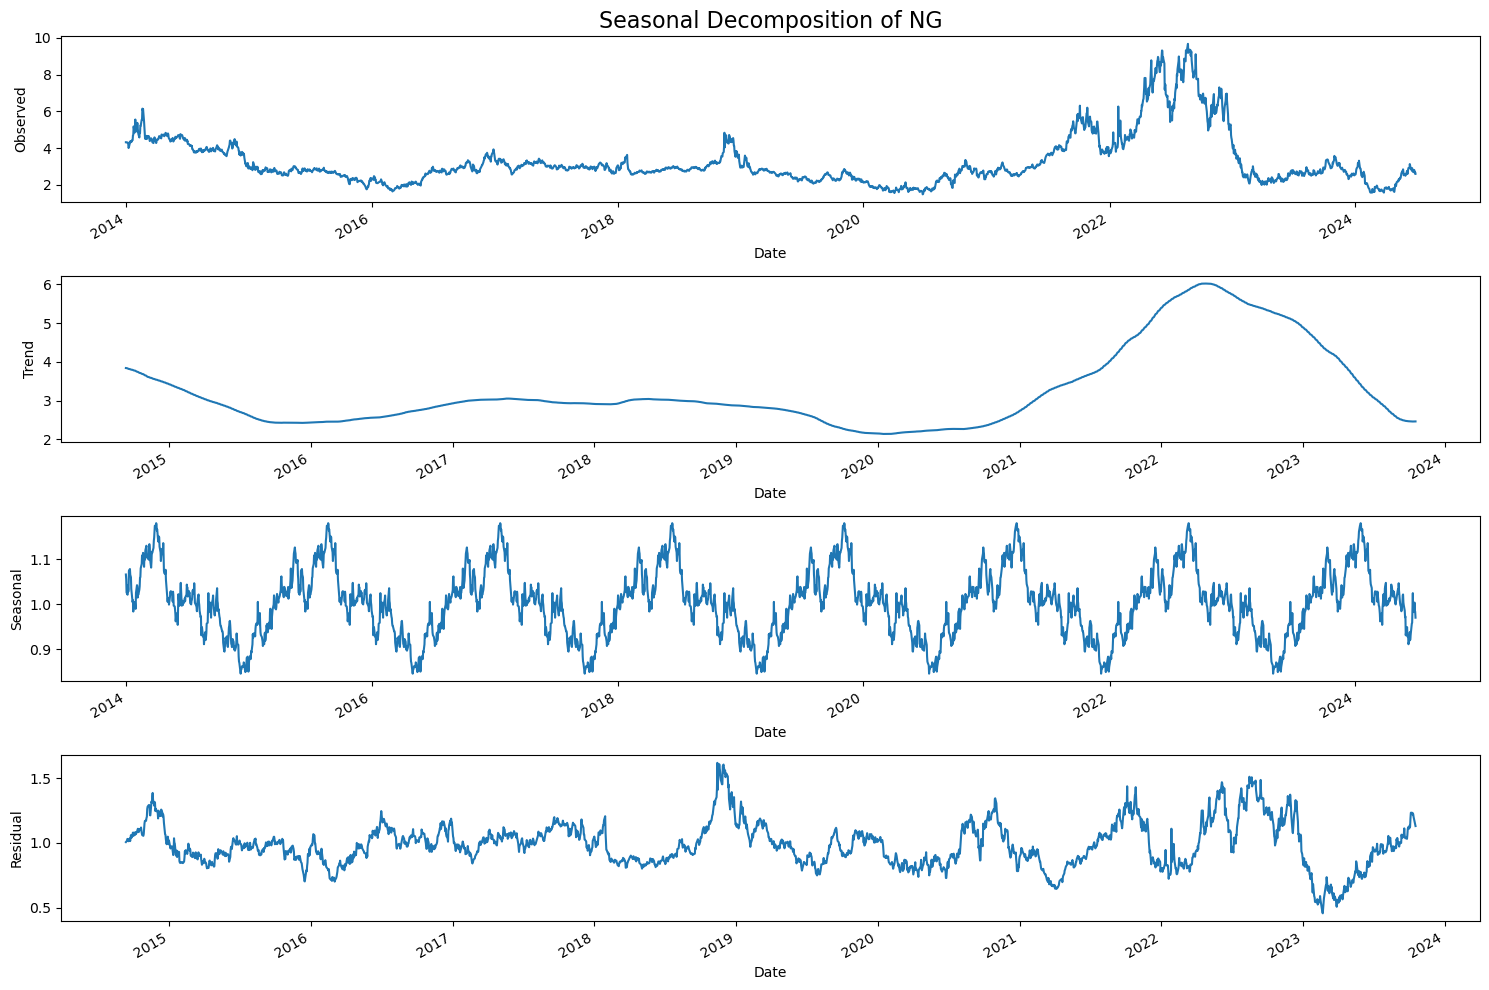

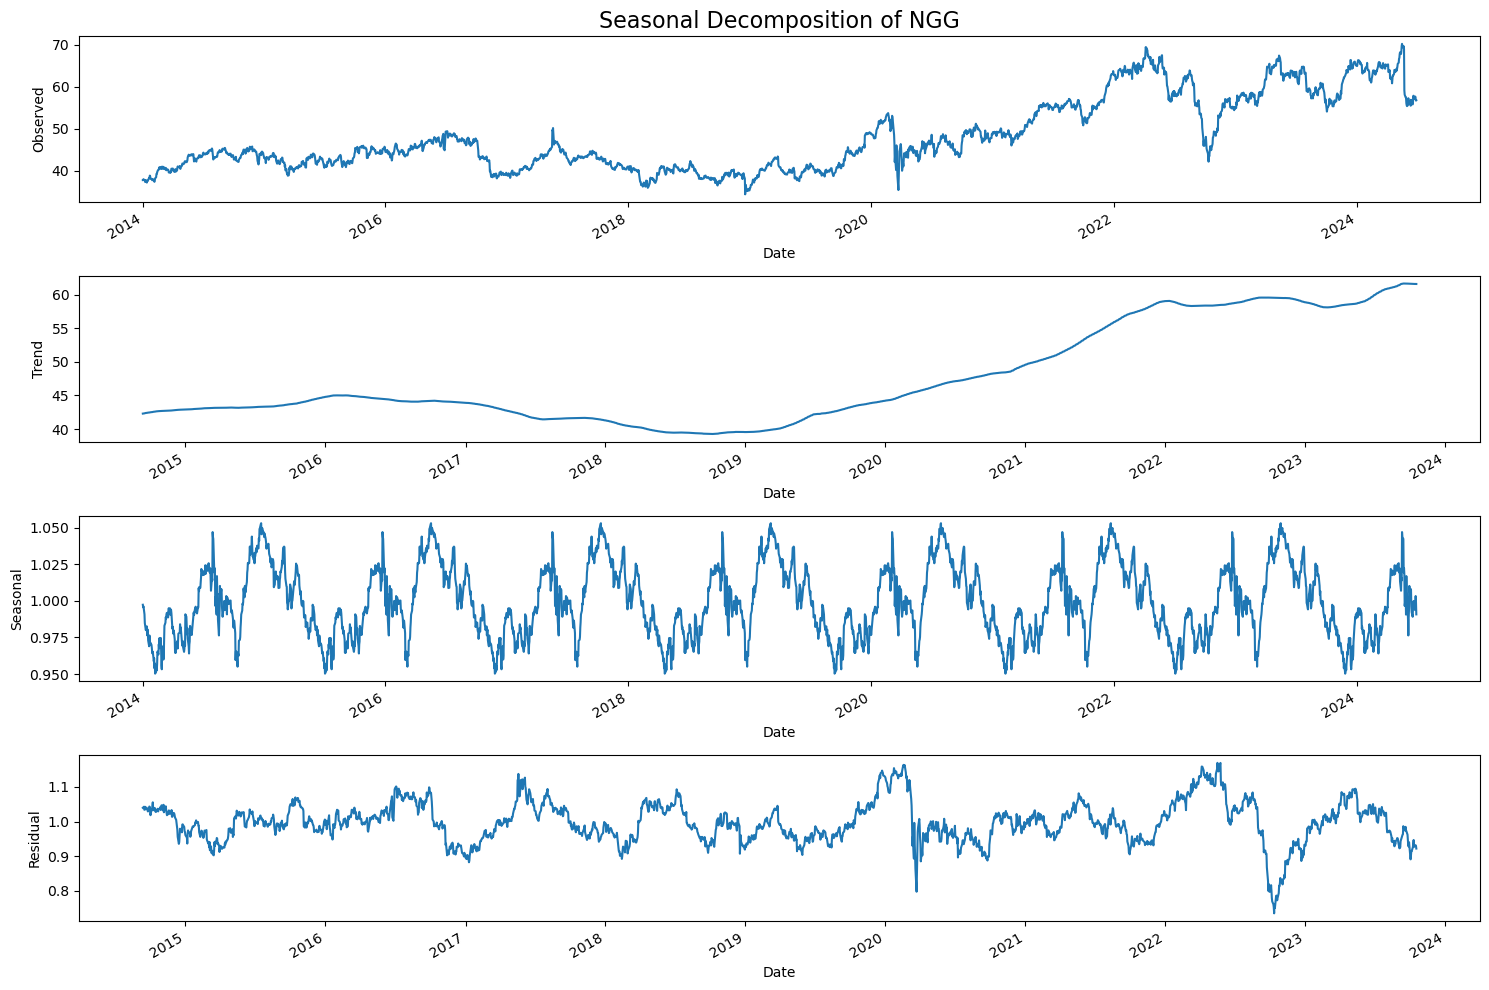

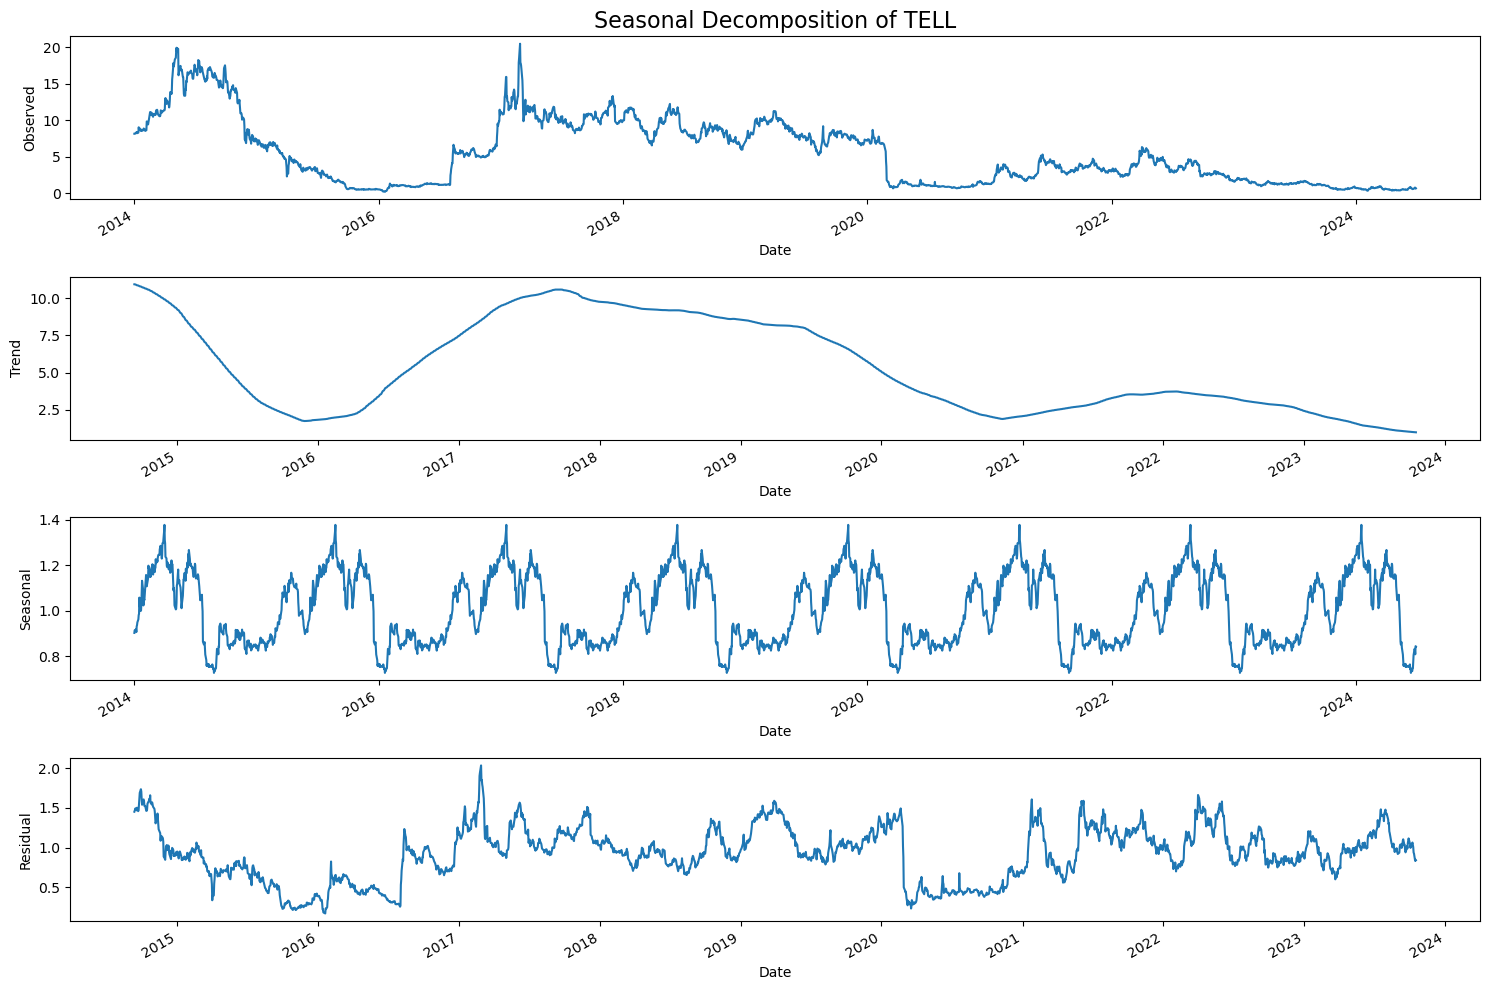

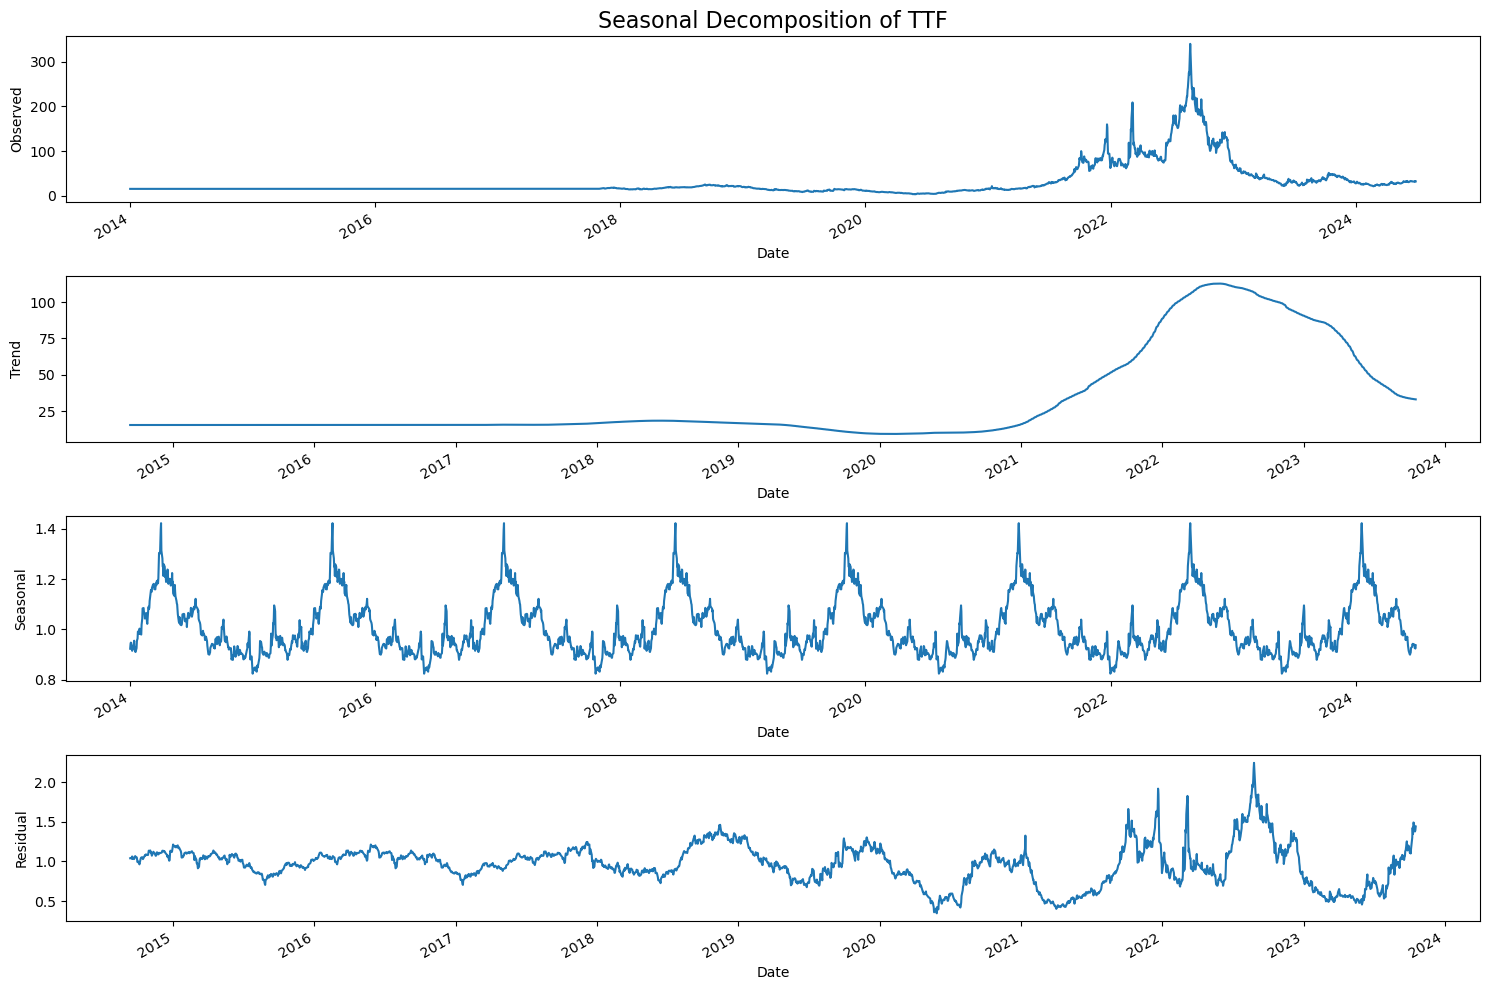

In [10]:
# Seasonal decomposition
for column in data_2.columns:
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(data_2[column], model='multiplicative', period=365)

    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    ax1.set_title(f'Seasonal Decomposition of {column}', fontsize=16)
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')

    plt.tight_layout()
    plt.show()

In [11]:
# return calculation
for column in data.columns:
    data[f'return_{column}'] = np.log(data[column]/data[column].shift(1))
data.head()

# rename columns
returns = data[['return_CL','return_LNG', 'return_NG', 'return_NGG', 'return_TELL', 'return_TTF']]
returns.head()

,return_CL,return_LNG,return_NG,return_NGG,return_TELL,return_TTF
Date,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2014-01-03,-0.015629,-0.024946,-0.003942,0.005734,0.000000,0.0
2014-01-06,-0.005657,0.021948,0.000465,-0.005890,0.019418,0.0
2014-01-07,0.002565,0.043166,-0.001627,-0.002023,-0.009662,0.0


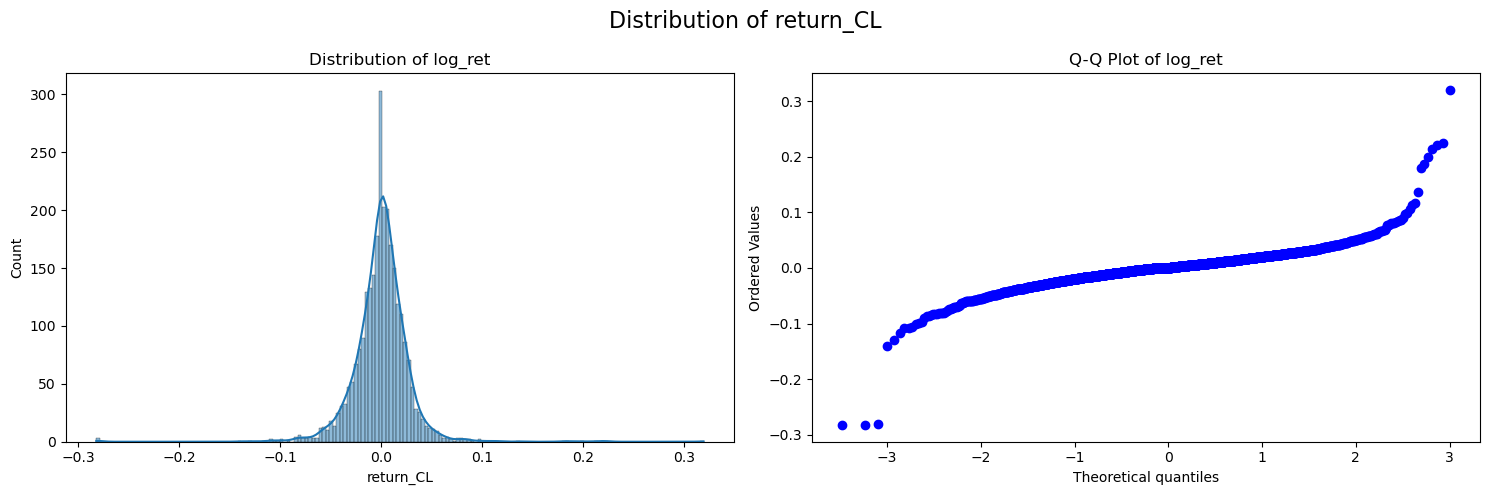

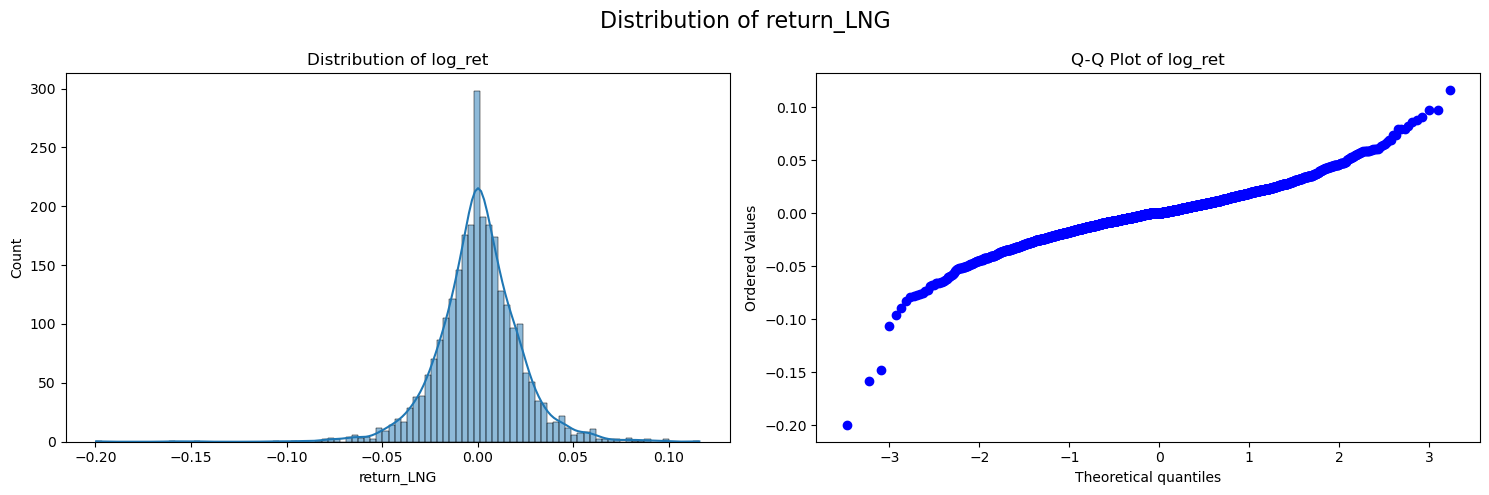

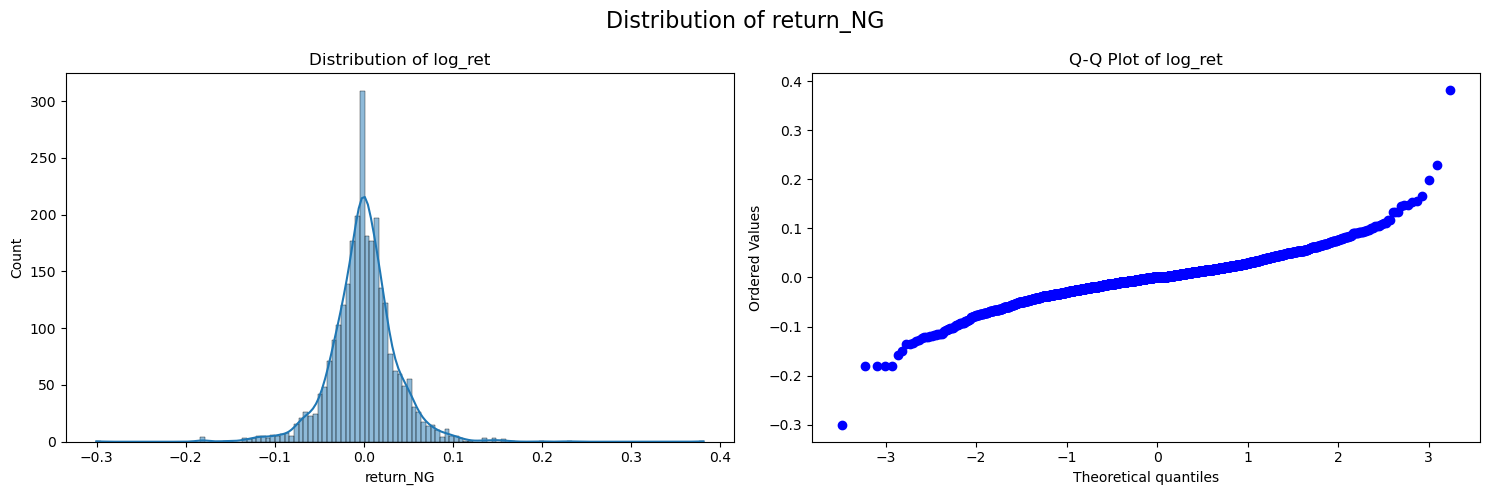

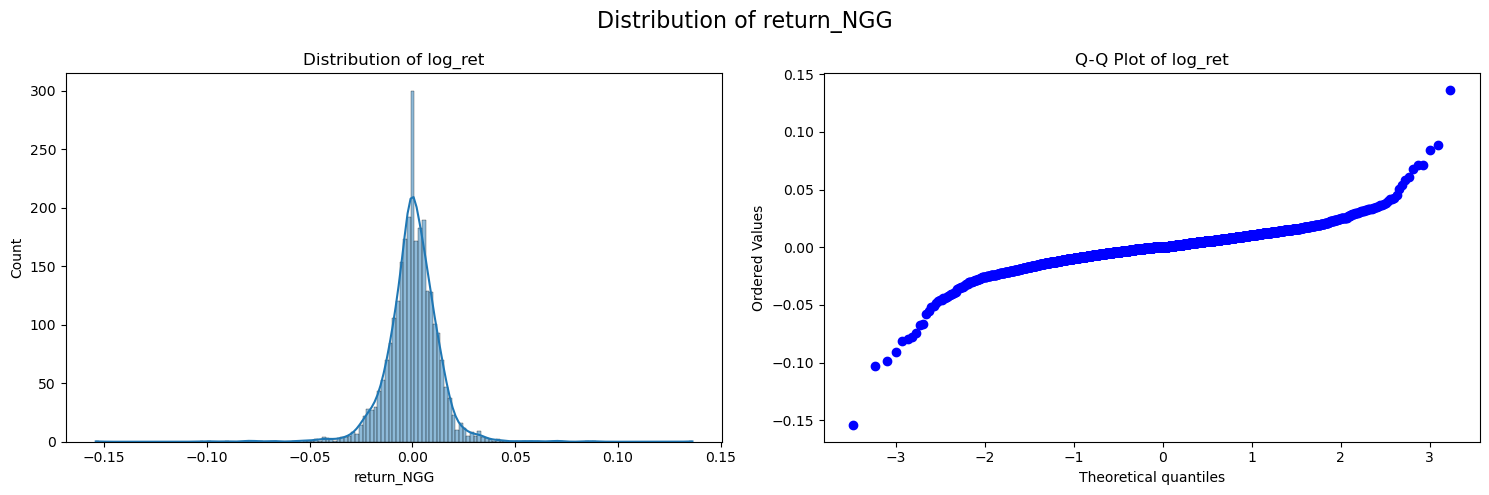

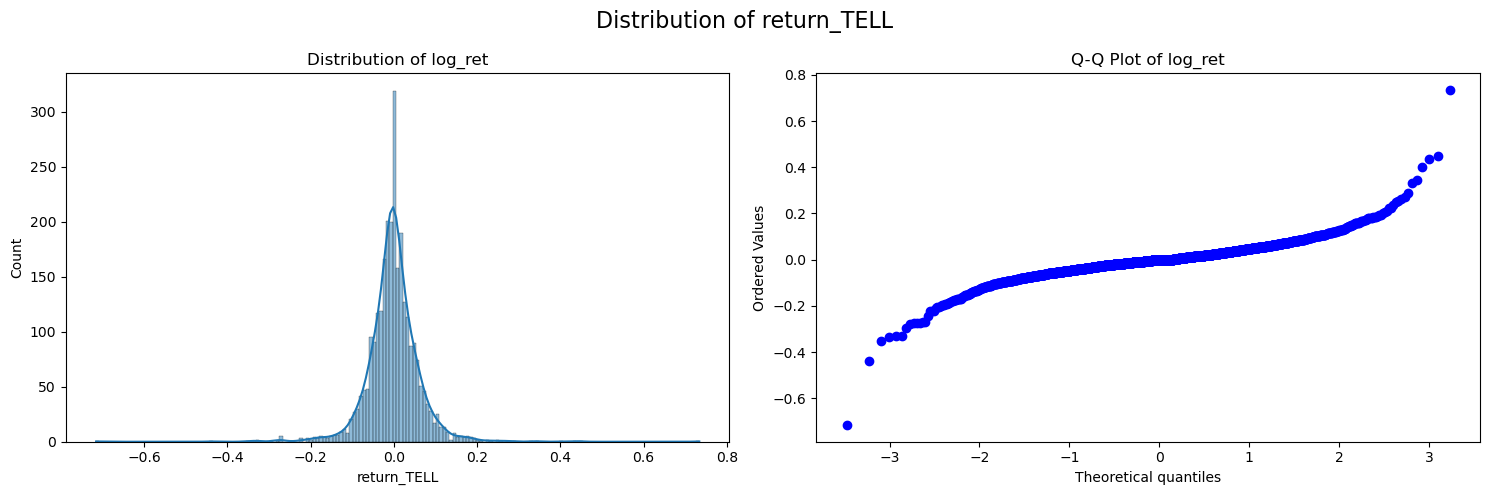

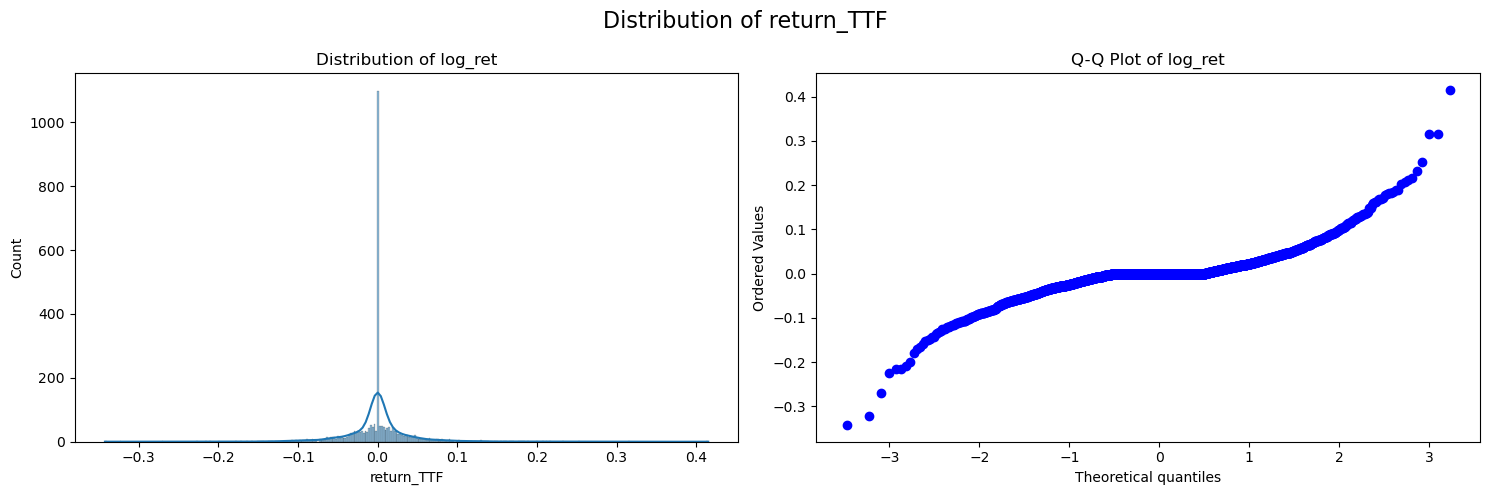

In [12]:
# check distribution shape
for column in returns.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot distribution plot
    sns.histplot(returns[column], kde=True, ax=ax1)
    ax1.set_title('Distribution of log_ret')

    # Plot Q-Q plot
    scipy.stats.probplot(returns[column], plot=ax2)
    ax2.set_title('Q-Q Plot of log_ret')
    
    # Display the plots
    fig.suptitle(f'Distribution of {column}', fontsize=16)
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

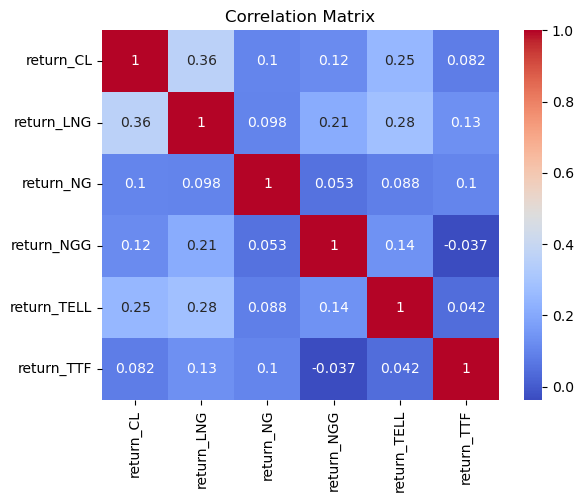

In [13]:
# Correlation Matrix of returns
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [14]:
# in table format
returns.corr()

,return_CL,return_LNG,return_NG,return_NGG,return_TELL,return_TTF
return_CL,1.000000,0.360985,0.102500,0.116998,0.248692,0.082057
return_LNG,0.360985,1.000000,0.098446,0.211428,0.281241,0.131705
return_NG,0.102500,0.098446,1.000000,0.053323,0.088498,0.103934
return_NGG,0.116998,0.211428,0.053323,1.000000,0.135921,-0.036990
return_TELL,0.248692,0.281241,0.088498,0.135921,1.000000,0.042243
return_TTF,0.082057,0.131705,0.103934,-0.036990,0.042243,1.000000


## Portfolio setup

In [15]:
np.random.seed(42)

# Number of simulations
num_simulations = 10000
num_assets = 6

# Initialize arrays to hold simulation results
results = np.zeros((4, num_simulations))
weights_record = np.zeros((num_assets, num_simulations))

# Run the Monte Carlo simulation
for i in range(num_simulations):
    # Generate random weights or initial guess
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # Calculate portfolio return and volatility
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Calculate Sharpe ratio (assuming risk-free rate is 0)
    sharpe_ratio = portfolio_return / portfolio_volatility
    
    # Store results
    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = sharpe_ratio
    results[3,i] = weights.max() 
    weights_record[:, i] = weights

# Convert results array to DataFrame
results_frame = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio', 'Max Weight'])
weights_frame = pd.DataFrame(weights_record.T, columns=returns.columns)

# Locate position of portfolio with highest Sharpe ratio
max_sharpe_idx = results_frame['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_frame.loc[max_sharpe_idx]
max_sharpe_weights = weights_frame.iloc[max_sharpe_idx]

# Results
print("Portfolio with Maximum Sharpe Ratio:")
print("Return:", max_sharpe_portfolio['Return'])
print("Volatility:", max_sharpe_portfolio['Volatility'])
print("Sharpe Ratio:", max_sharpe_portfolio['Sharpe Ratio'])
print("Weights:")
print(max_sharpe_weights)

Portfolio with Maximum Sharpe Ratio:
Return: 0.07175296180650627
Volatility: 0.2129511789140096
Sharpe Ratio: 0.3369455955699609
Weights:
return_CL      0.107747
return_LNG     0.392461
return_NG      0.002380
return_NGG     0.429591
return_TELL    0.015582
return_TTF     0.052239
Name: 8027, dtype: float64


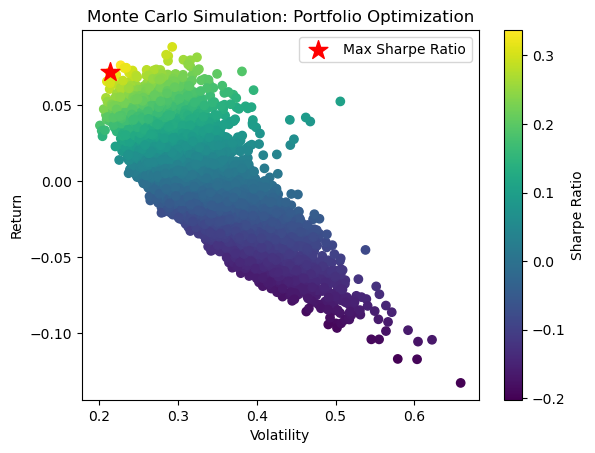

In [16]:
# Plot results
plt.scatter(results_frame.Volatility, results_frame.Return, c=results_frame['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], color='r', marker='*', s=200, label='Max Sharpe Ratio')
plt.title('Monte Carlo Simulation: Portfolio Optimization')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

# VaR model and ES Estimates

In [17]:
# significance level
alpha = 0.01
num_simulations = 10000

In [18]:
portfolio_returns = returns.dot(max_sharpe_weights)
portfolio_returns.dropna(inplace=True)
portfolio_returns = pd.DataFrame(data=portfolio_returns, columns=['returns'])
portfolio_returns.head()

,returns
Date,
2014-01-02,0.000000
2014-01-03,-0.009020
2014-01-06,0.005778
2014-01-07,0.016194
2014-01-08,0.003444


In [19]:
# Historical Approach
def historical_var(data):
    return np.percentile(data, alpha * 100)

def historical_es(data):
    var = historical_var(data)
    return data[data <= var].mean()

In [20]:
# Parametric Approach
def parametric_var(data):
    mu = np.mean(data)
    sigma = np.std(data)
    return mu + sigma * norm.ppf(alpha)

def parametric_es(data):
    mu = np.mean(data)
    sigma = np.std(data)
    return mu + sigma * norm.pdf(norm.ppf(alpha)) / alpha

In [21]:
# Monte Carlo Approach
def monte_carlo_var(data):
    np.random.seed(42)
    mu = np.mean(data)
    sigma = np.std(data)
    simulations = np.random.normal(mu, sigma, num_simulations)
    return np.percentile(simulations, alpha * 100)

def monte_carlo_es(data):
    np.random.seed(42)
    mu = np.mean(data)
    sigma = np.std(data)
    simulations = np.random.normal(mu, sigma, num_simulations)
    var = np.percentile(simulations, alpha * 100)
    return simulations[simulations <= var].mean()

In [22]:
event_windows_1 = [
    (pd.Timestamp('2014-06-01'), pd.Timestamp('2015-07-01')), # Oil Price Collapse started
    (pd.Timestamp('2015-07-14'), pd.Timestamp('2016-08-14')), # Iran Nuclear Deal
    (pd.Timestamp('2016-11-30'), pd.Timestamp('2017-06-05')), # OPEC Production Cuts
]

event_windows_2 = [    
    (pd.Timestamp('2017-06-05'), pd.Timestamp('2018-07-05')), # Qatar Diplomatic Crisis
    (pd.Timestamp('2018-05-08'), pd.Timestamp('2019-06-09')), # U.S. Withdrawal from Iran Nuclear Deal
    (pd.Timestamp('2019-09-14'), pd.Timestamp('2020-03-11')), # Attacks on Saudi Oil Facilities
]

event_windows_3 = [
    (pd.Timestamp('2020-03-11'), pd.Timestamp('2022-04-11')), # COVID-19 Pandemic
    (pd.Timestamp('2022-02-24'), pd.Timestamp('2024-01-01'))  # Russia-Ukraine War
]

In [23]:
# Jumping VaR model
def jump_VaR(choose_period, choose_events):
    np.random.seed(42)
    # Calculate daily returns
    daily_returns = choose_period.copy()

    # Define event windows around known geopolitical events
    event_windows = choose_events

    # Collect abnormal returns during event windows
    abnormal_returns = []
    for start, end in event_windows:
        event_returns = daily_returns.loc[start:end]
        abnormal_returns.extend(event_returns.values)

    # Convert to a NumPy array and filter out non-numeric values
    abnormal_returns = np.array(abnormal_returns)
    abnormal_returns = abnormal_returns[np.isfinite(abnormal_returns)]

    # Fit the jump size distribution
    mu_J, sigma_J = norm.fit(abnormal_returns)

    # Estimate jump intensity
    daily_returns = period_1_returns.copy().reset_index()
    total_years = (daily_returns['Date'].max() - daily_returns['Date'].min()).days / 365
    num_events = len(event_windows)
    lambda_jump = num_events / total_years

    # Parameters
    mu = daily_returns['returns'].mean()  # Drift
    sigma = daily_returns['returns'].std()  # Volatility
    T = 1 / 252  # 1-day horizon

    # Simulate returns
    simulated_returns = np.zeros(num_simulations)
    for i in range(num_simulations):
        jump_occurred = np.random.poisson(lambda_jump * T)  # Poisson process to determine if a jump occurs
        if jump_occurred:
            jump_size = np.random.normal(mu_J, sigma_J)
        else:
            jump_size = 0
        normal_return = np.random.normal(mu * T, sigma * np.sqrt(T))
        simulated_returns[i] = normal_return + jump_size

    # Calculate VaR and ES
    VaR_95 = np.percentile(simulated_returns, alpha*100)
    ES_95 = simulated_returns[simulated_returns <= VaR_95].mean()

    # Results
    print(f"Estimated Jump Intensity (lambda): {lambda_jump}")
    print(f"Estimated Jump Size Distribution (mean, std): ({mu_J}, {sigma_J})")
    print(f"Value at Risk (VaR) at 95% confidence level: {VaR_95:.4f}")
    print(f"Expected Shortfall (ES) at 95% confidence level: {ES_95:.4f}")
    return VaR_95, ES_95

In [24]:
# Kupiec test
def kupiec_test(realized_returns, VaR_values):
    realized_returns = np.array(realized_returns)
    VaR_values = np.array(VaR_values)
    # Number of observations
    n = len(realized_returns)
    # Number of exceptions
    num_exceptions = np.sum(realized_returns < -VaR_values)
    # Expected proportion of exceptions
    pi = alpha
    # Kupiec test statistic
    LR_pof = -2 * (num_exceptions * np.log(pi) + (n - num_exceptions) * np.log(1 - pi) - 
                   (num_exceptions * np.log(num_exceptions / n) + (n - num_exceptions) * np.log(1 - num_exceptions / n)))
    
    # p-value from chi-squared distribution with 1 degree of freedom
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    # Hypothesis result
    if p_value > alpha:
        result = "The null hypothesis is not rejected: the VaR model is accurate."
    else:
        result = "The null hypothesis is rejected: the VaR model is not accurate."
    print('pvalue:', p_value)
    print('Conclusion:', result)

## Split timeframe (3 smaller periods)

In [25]:
# Start and end dates transformed
start_date_0 = datetime.strptime(start_date_0, "%Y-%m-%d")
end_date_0 = datetime.strptime(end_date_0, "%Y-%m-%d")

# Calculate the total duration
total_duration = end_date_0 - start_date_0

# Calculate the duration of each smaller period
period_duration = total_duration / 3

# Generate the smaller periods
periods = []
current_start = start_date_0

for i in range(3):
    current_end = current_start + period_duration
    # Adjust the end date of the last period to be the overall end date
    if i == 2:
        current_end = end_date_0
    periods.append((current_start, current_end))
    current_start = current_end

# Transform datetime elements in periods to string
periods = [(start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')) for start, end in periods]

for i, (start, end) in enumerate(periods):
    print(f"Period {i+1}: Start = {start}, End = {end}")

Period 1: Start = 2014-01-01, End = 2017-07-02
Period 2: Start = 2017-07-02, End = 2020-12-31
Period 3: Start = 2020-12-31, End = 2024-07-01


In [26]:
# test the format of the date
periods[0][0]

'2014-01-01'

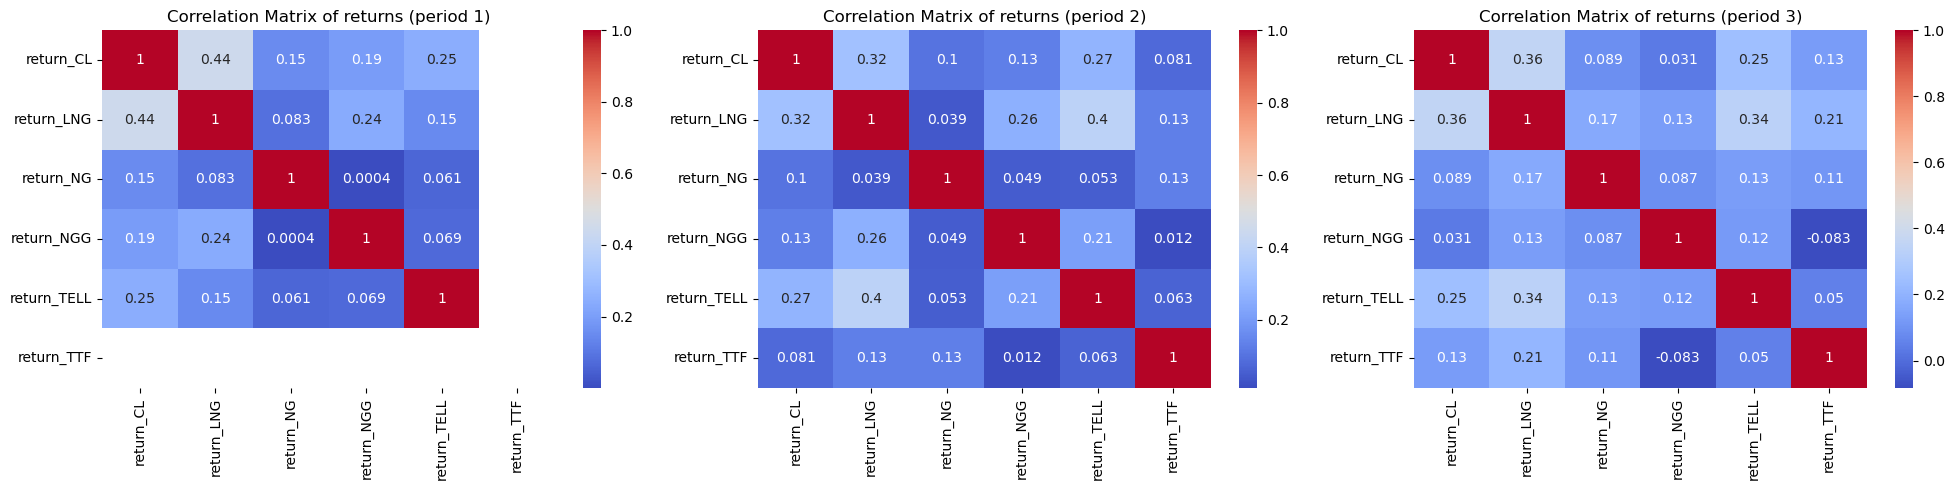

In [27]:
# plot the Correlation Matrix for 3 periods
p_1_returns = returns.loc[periods[0][0] : periods[0][1],:]
p_2_returns = returns.loc[periods[1][0] : periods[1][1],:]
p_3_returns = returns.loc[periods[2][0] : periods[2][1],:]


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(p_1_returns.corr(), annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Correlation Matrix of returns (period 1)')
sns.heatmap(p_2_returns.corr(), annot=True, cmap='coolwarm', ax=ax2)
ax2.set_title('Correlation Matrix of returns (period 2)')
sns.heatmap(p_3_returns.corr(), annot=True, cmap='coolwarm', ax=ax3)
ax3.set_title('Correlation Matrix of returns (period 3)')
plt.tight_layout()
plt.show()

In [28]:
# compare correlation
def flatten_corr_matrix(df, period_name):
    corr_matrix = df.corr()
    corr_flat = corr_matrix.unstack().reset_index()
    corr_flat.columns = ['Stock_1', 'Stock_2', period_name]
    corr_flat = corr_flat[corr_flat['Stock_1'] != corr_flat['Stock_2']]
    corr_flat['Pair'] = corr_flat.apply(lambda row: tuple(sorted([row['Stock_1'], row['Stock_2']])), axis=1)
    corr_flat = corr_flat.drop_duplicates(subset='Pair').drop(columns='Pair').reset_index(drop=True)
    return corr_flat

# Flatten the correlation matrices
corr_flat1 = flatten_corr_matrix(p_1_returns, 'Correlation_Period_1')
corr_flat2 = flatten_corr_matrix(p_2_returns, 'Correlation_Period_2')
corr_flat3 = flatten_corr_matrix(p_3_returns, 'Correlation_Period_3')

# Merge the flattened correlation DataFrames
merged_corr = corr_flat1.merge(corr_flat2, on=['Stock_1', 'Stock_2']).merge(corr_flat3, on=['Stock_1', 'Stock_2'])

# Display the merged DataFrame
merged_corr

,Stock_1,Stock_2,Correlation_Period_1,Correlation_Period_2,Correlation_Period_3
0,return_CL,return_LNG,0.442976,0.317625,0.355278
1,return_CL,return_NG,0.152574,0.101817,0.088753
2,return_CL,return_NGG,0.193343,0.129036,0.031480
3,return_CL,return_TELL,0.245361,0.272340,0.246372
4,return_CL,return_TTF,NaN,0.080703,0.127421
5,return_LNG,return_NG,0.083411,0.039242,0.168471
6,return_LNG,return_NGG,0.236574,0.259243,0.129715
7,return_LNG,return_TELL,0.145259,0.397405,0.335348
8,return_LNG,return_TTF,NaN,0.131385,0.211499
9,return_NG,return_NGG,0.000403,0.049319,0.087314


In [29]:
# split the portfolio returns into 3 periods, using the weights calculated above
period_1_returns = portfolio_returns.loc[periods[0][0] : periods[0][1],:]
period_2_returns = portfolio_returns.loc[periods[1][0] : periods[1][1],:]
period_3_returns = portfolio_returns.loc[periods[2][0] : periods[2][1],:]

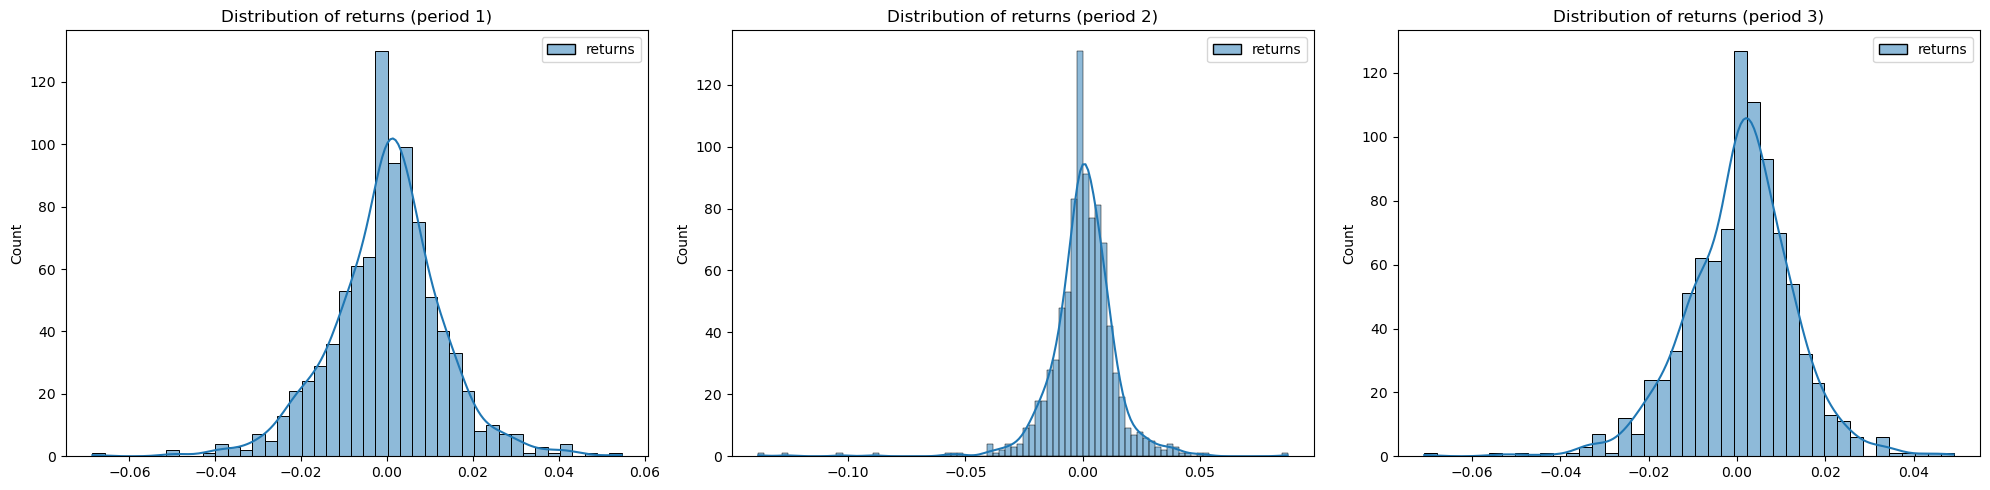

In [30]:
# plot the distribution for the assumption for VaR model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(period_1_returns, kde=True, ax=ax1)
ax1.set_title('Distribution of returns (period 1)')

sns.histplot(period_2_returns, kde=True, ax=ax2)
ax2.set_title('Distribution of returns (period 2)')

sns.histplot(period_3_returns, kde=True, ax=ax3)
ax3.set_title('Distribution of returns (period 3)')

plt.tight_layout()
plt.show()

### Period 1

#### Historical Approach

In [31]:
historical_var(period_1_returns)

-0.0345360025271998

In [32]:
historical_es(period_1_returns)

returns   -0.043395
dtype: float64

In [33]:
kupiec_test(period_1_returns, historical_var(period_1_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Parametric Approach

In [34]:
parametric_var(period_1_returns)

returns   -0.030169
dtype: float64

In [35]:
parametric_es(period_1_returns)

returns    0.034621
dtype: float64

In [36]:
kupiec_test(period_1_returns, parametric_var(period_1_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Monte Carlo Approach

In [37]:
monte_carlo_var(period_1_returns)

-0.030093632029392928

In [38]:
monte_carlo_es(period_1_returns)

-0.03497794218523088

In [39]:
kupiec_test(period_1_returns, monte_carlo_var(period_1_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Jumping VaR model

In [40]:
Var_1, ES_1 = jump_VaR(period_1_returns, event_windows_1)

Estimated Jump Intensity (lambda): 0.8588235294117647
Estimated Jump Size Distribution (mean, std): (-8.62372308386251e-05, 0.013595892328641527)
Value at Risk (VaR) at 95% confidence level: -0.0020
Expected Shortfall (ES) at 95% confidence level: -0.0033


In [41]:
kupiec_test(period_1_returns, Var_1)

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


### Period 2

#### Historical Approach

In [42]:
historical_var(period_2_returns)

-0.03905659301999814

In [43]:
historical_es(period_2_returns)

returns   -0.073964
dtype: float64

In [44]:
kupiec_test(period_2_returns, historical_var(period_2_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Parametric Approach

In [45]:
parametric_var(period_2_returns)

returns   -0.034258
dtype: float64

In [46]:
parametric_es(period_2_returns)

returns    0.039702
dtype: float64

In [47]:
kupiec_test(period_2_returns, parametric_var(period_2_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Monte Carlo Approach

In [48]:
monte_carlo_var(period_2_returns)

-0.03417178644233906

In [49]:
monte_carlo_es(period_2_returns)

-0.03974739631371842

In [50]:
kupiec_test(period_2_returns, monte_carlo_var(period_2_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Jumping VaR model

In [51]:
Var_2, ES_2 = jump_VaR(period_2_returns, event_windows_2)

Estimated Jump Intensity (lambda): 0.8588235294117647
Estimated Jump Size Distribution (mean, std): (-0.0001785723906711443, 0.01139745580324349)
Value at Risk (VaR) at 95% confidence level: -0.0020
Expected Shortfall (ES) at 95% confidence level: -0.0031


In [52]:
kupiec_test(period_2_returns, Var_2)

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


### Period 3

#### Historical Approach

In [53]:
historical_var(period_3_returns)

-0.03279676669961131

In [54]:
historical_es(period_3_returns)

returns   -0.042423
dtype: float64

In [55]:
kupiec_test(period_3_returns, historical_var(period_3_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Parametric Approach

In [56]:
parametric_var(period_3_returns)

returns   -0.027987
dtype: float64

In [57]:
parametric_es(period_3_returns)

returns    0.033422
dtype: float64

In [58]:
kupiec_test(period_3_returns, parametric_var(period_3_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Monte Carlo Approach

In [59]:
monte_carlo_var(period_3_returns)

-0.02791574315718431

In [60]:
monte_carlo_es(period_3_returns)

-0.03254517218179013

In [61]:
kupiec_test(period_3_returns, monte_carlo_var(period_3_returns))

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


#### Jumping VaR model

In [62]:
Var_3, ES_3 = jump_VaR(period_3_returns, event_windows_3)

Estimated Jump Intensity (lambda): 0.5725490196078431
Estimated Jump Size Distribution (mean, std): (0.0008800526841871334, 0.012934143886289062)
Value at Risk (VaR) at 95% confidence level: -0.0020
Expected Shortfall (ES) at 95% confidence level: -0.0028


In [63]:
kupiec_test(period_3_returns, Var_3)

pvalue: 0.0
Conclusion: The null hypothesis is rejected: the VaR model is not accurate.


### Results

In [64]:
# prepare the list for a dataframe of results
list_period_1 = [historical_var(period_1_returns),historical_es(period_1_returns).values[0],
                 parametric_var(period_1_returns).values[0],parametric_es(period_1_returns).values[0],
                 monte_carlo_var(period_1_returns),monte_carlo_es(period_1_returns), Var_1, ES_1]


list_period_2 = [historical_var(period_2_returns),historical_es(period_2_returns).values[0],
                 parametric_var(period_2_returns).values[0],parametric_es(period_2_returns).values[0],
                 monte_carlo_var(period_2_returns),monte_carlo_es(period_2_returns), Var_2, ES_2]


list_period_3 = [historical_var(period_3_returns),historical_es(period_3_returns).values[0],
                 parametric_var(period_3_returns).values[0],parametric_es(period_3_returns).values[0],
                 monte_carlo_var(period_3_returns),monte_carlo_es(period_3_returns), Var_3, ES_3]

list_approach = ['Historical Simulation', 'Historical Simulation', 
                 'Variance-Covariance Method', 'Variance-Covariance Method', 
                 'Monte Carlo Simulation', 'Monte Carlo Simulation', 'Jumping VaR', 'Jumping VaR']

list_var = ['VaR', 'ES', 'VaR', 'ES', 'VaR', 'ES', 'VaR', 'ES']

In [65]:
# Collecting all results in table format
result_var_es = pd.DataFrame(data={'Approach': list_approach,
                  'Metric' : list_var,
                  'Period 1': list_period_1, 
                  'Period 2': list_period_2,
                  'Period 3': list_period_3,})

round(result_var_es,4)

,Approach,Metric,Period 1,Period 2,Period 3
0,Historical Simulation,VaR,-0.0345,-0.0391,-0.0328
1,Historical Simulation,ES,-0.0434,-0.0740,-0.0424
2,Variance-Covariance Method,VaR,-0.0302,-0.0343,-0.0280
3,Variance-Covariance Method,ES,0.0346,0.0397,0.0334
4,Monte Carlo Simulation,VaR,-0.0301,-0.0342,-0.0279
5,Monte Carlo Simulation,ES,-0.0350,-0.0397,-0.0325
6,Jumping VaR,VaR,-0.0020,-0.0020,-0.0020
7,Jumping VaR,ES,-0.0033,-0.0031,-0.0028
